In [1]:
import tensorflow as tf
import math
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation split

batch_size = 20
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\Nikhil Totla\data1\train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',  # 'binary' for binary classification
    subset='training'     # Specify subset as 'training' for training data
)

validation_generator = train_datagen.flow_from_directory(
    r'C:\Users\Nikhil Totla\data1\train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',  # 'binary' for binary classification
    subset='validation'   # Specify subset as 'validation' for validation data
)

Found 832 images belonging to 6 classes.
Found 204 images belonging to 6 classes.


In [5]:
num_classes=len(train_generator[0][1][0])

In [9]:

#Loss function
def cosface_loss(y_true, y_pred):
    scale = 30.0
    margin = 0.35
    M=math.e**margin

    # L2 normalize embeddings
    y_pred = K.l2_normalize(y_pred, axis=1)

    # Compute the cosine similarity between y_pred and class centers
    similarity = K.sum((y_true * y_pred), axis=1)

    # CosFace loss
    cos_loss = K.mean(tf.math.acos((similarity-margin)/M) * scale)
#     print(M)

    return cos_loss

# Define margin and scale values to search through
# M= math.e**margin
# print(M)

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation=None)  #  classification output
])

model.compile(optimizer='adam', loss=cosface_loss, metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, validation_data=validation_generator)

Epoch 1/25
42/42 [==============================] - 41s 956ms/step - loss: 45.5542 - accuracy: 0.3065 - val_loss: 44.7091 - val_accuracy: 0.3284
Epoch 2/25
42/42 [==============================] - 31s 744ms/step - loss: 44.6746 - accuracy: 0.3269 - val_loss: 44.5599 - val_accuracy: 0.3284
Epoch 3/25
42/42 [==============================] - 31s 744ms/step - loss: 43.9954 - accuracy: 0.3594 - val_loss: 43.3191 - val_accuracy: 0.4657
Epoch 4/25
42/42 [==============================] - 32s 766ms/step - loss: 42.7206 - accuracy: 0.4651 - val_loss: 43.3694 - val_accuracy: 0.4314
Epoch 5/25
42/42 [==============================] - 31s 743ms/step - loss: 41.3626 - accuracy: 0.5745 - val_loss: 41.3708 - val_accuracy: 0.5245
Epoch 6/25
42/42 [==============================] - 32s 772ms/step - loss: 39.9143 - accuracy: 0.6719 - val_loss: 39.5744 - val_accuracy: 0.6618
Epoch 7/25
42/42 [==============================] - 30s 724ms/step - loss: 38.1619 - accuracy: 0.7776 - val_loss: 38.7764 - val_ac

11/11 [==============================] - 1s 96ms/step - loss: 35.2438 - accuracy: 0.8922
Test Loss: 35.2438
Test Accuracy: 0.8922


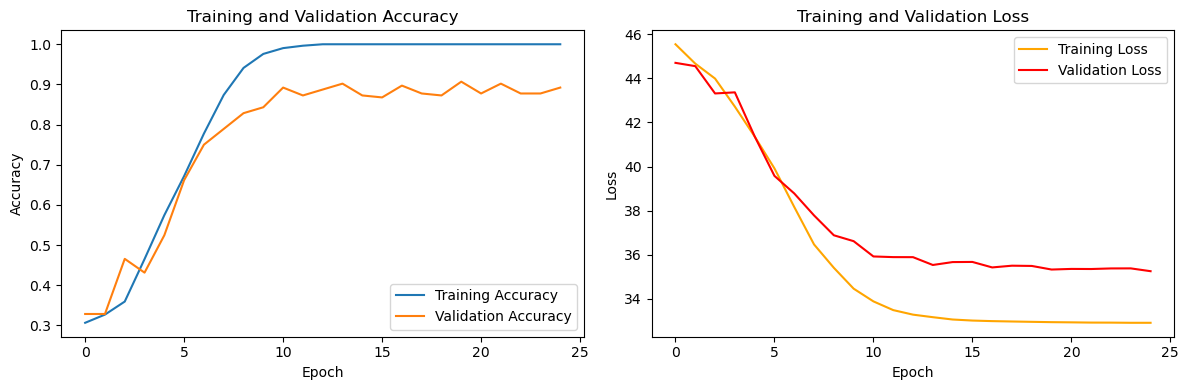

11/11 [==============================] - 1s 104ms/step


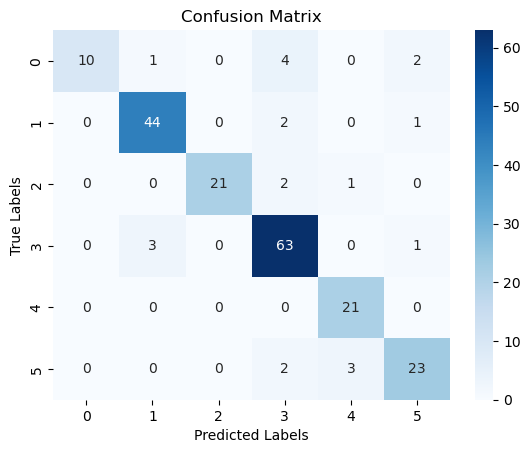


Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       1.00      0.59      0.74        17
     Colin_Powell       0.92      0.94      0.93        47
  Donald_Rumsfeld       1.00      0.88      0.93        24
    George_W_Bush       0.86      0.94      0.90        67
Gerhard_Schroeder       0.84      1.00      0.91        21
       Tony_Blair       0.85      0.82      0.84        28

         accuracy                           0.89       204
        macro avg       0.91      0.86      0.87       204
     weighted avg       0.90      0.89      0.89       204



In [11]:
test_generator=validation_generator
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions and Confusion Matrix

# Initialize lists to store data and labels
# x_test = []
y_test = []

# Calculate the number of batches needed to process the entire dataset
num_batches = len(test_generator)

# Loop through each batch and collect data and labels
for i in range(num_batches):
    batch_x, batch_y = test_generator.next()
    # x_test.append(batch_x)
    y_test.append(batch_y)

# Convert the lists to NumPy arrays if needed
# x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


y_pred = model.predict(test_generator)
# Convert predictions to label index
y_pred_argmax = tf.argmax(y_pred, axis=1)
y_test_argmax = tf.argmax(y_test, axis=1)


confusion = confusion_matrix(y_test_argmax, y_pred_argmax)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
class_report = classification_report(y_test_argmax, y_pred_argmax, target_names=test_generator.class_indices)
print("\nClassification Report:")
print(class_report)